# Introduction

The goal of this project is to build a functional framework to create album artwork collages for your favorite music.

We will be using Spotify's API to access album artwork.

## Available Collage Designs:
- 2 x 2
- 3 x 3
- 4 x 4
- 4 x 4 w/ Centerpiece
- 4 x 4 w/ Top/Bottom Borders
- 5 x 5
- 5 x 5 w/ Centerpiece
- 5 x 5 w/ Corner Centerpieces

## Import Packages

In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

from PIL import Image
import requests
from io import BytesIO

## Access Spotify API

In [2]:
# id and secret removed
client_id = '[CLIENT_ID]'
client_secret = '[CLIENT_SECRET]'

client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)
spotify = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

## Define Functions for Accessing & Sizing Album Artwork

In [3]:
def get_album_urls(album_uri_list):
    url_list = []
    for uri in album_uri_list:
        album_data = spotify.album(uri)
        url = album_data['images'][0]['url']
        url_list.append(url)
        
    return url_list

def make_template(album_art_url):
    response = requests.get(album_art_url)
    template = Image.open(BytesIO(response.content))
    return template

def make_border(album_art_url, side_length):
    response = requests.get(album_art_url)
    img = Image.open(BytesIO(response.content))
    width, height = img.size
    return img.resize((int(width / side_length), int(height / side_length)))

def make_centerpiece(album_art_url, side_length):
    response = requests.get(album_art_url)
    img = Image.open(BytesIO(response.content))
    width, height = img.size
    return img.resize((int(width * 2 / side_length), int(height * 2 / side_length)))

## Define Function for Creating Collage

In [4]:
def make_collage(side_length, border_albums, centerpiece_albums = []):
    '''
    Inputs:
        side_length (int): the output collage will be of size side_length x side_length, 
                           where side_length is the number of border pieces that fill a side
                           minimum: 1
                           maximum: 5
        border_albums (list): a list of Spotify album URIs which will be converted to
                           album artwork and used as border pieces in output collage
        centerpiece_albums (list): a list of Spotify album URIs which will be converted to
                           album artwork and used as centerpieces in output collage
                           default: [] (empty list)
                           
    Output:
        a side_length x side_length collage of album covers with optional centerpieces
        resulting image is 640 x 640 pixels
    '''
    
    if (side_length < 1) or (side_length > 5):
        print('Invalid side_length.  side_length should be from 1 to 5.')
    
    url_list = get_album_urls(border_albums)
    centerpiece_list = get_album_urls(centerpiece_albums)
    
    borders = len(url_list)
    centers = len(centerpiece_list)
    
    if (side_length == 1):
        style = 'no centerpiece'
        url_list = url_list + centerpiece_list
        if (len(url_list) != 1):
            print('Invalid number of albums inputted for side_length = 1.  Input exactly 1 album.')
    
    if (side_length == 2):
        style = 'no centerpiece'
        url_list = url_list + centerpiece_list
        if (len(url_list) != 4):
            print('Invalid number of albums inputted for side_length = 2.  Input exactly 4 albums.')
        
    if (side_length == 3):
        style = 'no centerpiece'
        url_list = url_list + centerpiece_list
        if (len(url_list) != 9):
            print('Invalid number of albums inputted for side_length = 3.  Input exactly 9 albums.')
            
    if (side_length == 4):
        if (borders == 16) and (centers == 0):
            style = 'no centerpiece'
        elif (borders == 12) and (centers == 1):
            style = 'single centerpiece'
        elif (borders == 8) and (centers == 2):
            style = 'top bottom border'
        else:
            print('Invalid number of albums inputted for side_length = 4.\n\n' +
                  'Options:\n' +
                  '   - 16 border pieces & 0 center pieces\n' +
                  '   - 12 border pieces & 1 center piece\n' +
                  '   - 8 border pieces & 2 center pieces\n')
    
    if (side_length == 5):
        if (borders == 25) and (centers == 0):
            style = 'no centerpiece'
        elif (borders == 9) and (centers == 4):
            style = 'plus'
        else:
            print('Invalid number of albums inputted for side_length = 5.\n\n' +
                  'Options:\n' +
                  '   - 25 border pieces & 0 center pieces\n' +
                  '   - 9 border pieces & 4 center pieces\n')
    
    x, y = 0, 0
    # template is 640 x 640 pixels
    template = make_template('https://i.scdn.co/image/ab67616d0000b273af07dc851962508661bbcfce') # Metallica cover
    img_length = int(640 / side_length)
    
    if side_length == 3:
        end_row = 640 - 1 - img_length  # accounts for rounding img_length float down to int
        template = template.crop((0, 0, 639, 639)) # fix extra pixel rounding bug
    else:
        end_row = 640 - img_length
        
    for piece in centerpiece_list:
        centerpiece = make_centerpiece(piece, side_length)
        if style == 'single centerpiece':
            template.paste(centerpiece, (img_length, img_length))
        elif style == 'top bottom border':
            template.paste(centerpiece, (x, img_length))
            x += 320
        elif style == 'plus':
            template.paste(centerpiece, (x, y))
            if x == 0 and y == 0:
                x += 384
            elif x == 384 and y == 0:
                y += 384
            elif x == 384 and y == 384:
                x -= 384
                
    if style == 'plus':
        x = 256
    else:
        x = 0
    y = 0
    
    for url in url_list:
        img = make_border(url, side_length)
        template.paste(img, (x, y))
        
        if style == 'no centerpiece':
            if x == end_row:
                x = 0
                y += img_length
            else:
                x += img_length
                
        elif style == 'single centerpiece':
            if x == end_row:
                x = 0
                y += img_length
            elif y == 0 or y == end_row:
                x += img_length
            elif x == 0 and y != 0:
                x += end_row
                
        elif style == 'top bottom border':   
            if x == end_row:
                x = 0
                y = end_row
            elif y == 0 or y == end_row:
                x += int(img_length)
                
        elif style == 'plus':
            if y == img_length:
                x = 0
                y += img_length
            elif x == end_row:
                x = 256
                y += img_length
            elif y == 256:
                x += 128
            else:
                y += img_length
                
    return template

# Collage Examples...

### Album URI Lists

In [5]:
test1 = ['spotify:album:2d4eS9a7DRTlfeTKVJQ0kr']

test2 = ['spotify:album:7mzrIsaAjnXihW3InKjlC3',
         'spotify:album:2dqn5yOQWdyGwOpOIi9O4x']

test4 = ['spotify:album:7mzrIsaAjnXihW3InKjlC3',
         'spotify:album:2dqn5yOQWdyGwOpOIi9O4x',
         'spotify:album:5EpMjweRD573ASl7uNiHym',
         'spotify:album:4aHakdIA1e8HoRRUsYszDY']

test8 = ['spotify:album:6j6uNK4vsfLXqVwWXwvqYQ',
         'spotify:album:5GP6INOrUkZJyXOqoTUlxZ',
         'spotify:album:62XZju4HxxXF6CBIqqG2ei',
         'spotify:album:5e3Kjap4XBZ44dc36AqtEo',
         'spotify:album:0wEnZguPw6l4Rcdgzcm5qv',
         'spotify:album:5dtw6CoMhbrSj01YUvdQOF',
         'spotify:album:1IR2nlwX6YVTXXeu2qzoWO',
         'spotify:album:6JlCkqkqobGirPsaleJpFr']

test9 = ['spotify:album:6j6uNK4vsfLXqVwWXwvqYQ',
         'spotify:album:5GP6INOrUkZJyXOqoTUlxZ',
         'spotify:album:62XZju4HxxXF6CBIqqG2ei',
         'spotify:album:5e3Kjap4XBZ44dc36AqtEo',
         'spotify:album:0wEnZguPw6l4Rcdgzcm5qv',
         'spotify:album:5dtw6CoMhbrSj01YUvdQOF',
         'spotify:album:1IR2nlwX6YVTXXeu2qzoWO',
         'spotify:album:6JlCkqkqobGirPsaleJpFr',
         'spotify:album:62aYom0k3j1RBe4uPC64ob']

test10 = ['spotify:album:6j6uNK4vsfLXqVwWXwvqYQ',
         'spotify:album:5GP6INOrUkZJyXOqoTUlxZ',
         'spotify:album:62XZju4HxxXF6CBIqqG2ei',
         'spotify:album:5e3Kjap4XBZ44dc36AqtEo',
         'spotify:album:0wEnZguPw6l4Rcdgzcm5qv',
         'spotify:album:5dtw6CoMhbrSj01YUvdQOF',
         'spotify:album:1IR2nlwX6YVTXXeu2qzoWO',
         'spotify:album:6JlCkqkqobGirPsaleJpFr',
         'spotify:album:62aYom0k3j1RBe4uPC64ob',
         'spotify:album:1QIZsTZrZdQwQ9QJnFoFao']

test12 = ['spotify:album:6j6uNK4vsfLXqVwWXwvqYQ',
         'spotify:album:5GP6INOrUkZJyXOqoTUlxZ',
         'spotify:album:62XZju4HxxXF6CBIqqG2ei',
         'spotify:album:5e3Kjap4XBZ44dc36AqtEo',
         'spotify:album:0wEnZguPw6l4Rcdgzcm5qv',
         'spotify:album:5dtw6CoMhbrSj01YUvdQOF',
         'spotify:album:1IR2nlwX6YVTXXeu2qzoWO',
         'spotify:album:6JlCkqkqobGirPsaleJpFr',
         'spotify:album:62aYom0k3j1RBe4uPC64ob',
         'spotify:album:1QIZsTZrZdQwQ9QJnFoFao',
         'spotify:album:7Ad3sRoSJmRcjtd5Ce27Oj',
         'spotify:album:53Oa5Bu0UTU8o8qCTaHKoz']

test13 = ['spotify:album:6j6uNK4vsfLXqVwWXwvqYQ',
         'spotify:album:5GP6INOrUkZJyXOqoTUlxZ',
         'spotify:album:62XZju4HxxXF6CBIqqG2ei',
         'spotify:album:5e3Kjap4XBZ44dc36AqtEo',
         'spotify:album:0wEnZguPw6l4Rcdgzcm5qv',
         'spotify:album:5dtw6CoMhbrSj01YUvdQOF',
         'spotify:album:1IR2nlwX6YVTXXeu2qzoWO',
         'spotify:album:6JlCkqkqobGirPsaleJpFr',
         'spotify:album:62aYom0k3j1RBe4uPC64ob',
         'spotify:album:1QIZsTZrZdQwQ9QJnFoFao',
         'spotify:album:7Ad3sRoSJmRcjtd5Ce27Oj',
         'spotify:album:53Oa5Bu0UTU8o8qCTaHKoz',
         'spotify:album:0S9D5NIDp2YXhYwlvuJzqx']

test16 = ['spotify:album:6j6uNK4vsfLXqVwWXwvqYQ',
         'spotify:album:5GP6INOrUkZJyXOqoTUlxZ',
         'spotify:album:62XZju4HxxXF6CBIqqG2ei',
         'spotify:album:5e3Kjap4XBZ44dc36AqtEo',
         'spotify:album:0wEnZguPw6l4Rcdgzcm5qv',
         'spotify:album:5dtw6CoMhbrSj01YUvdQOF',
         'spotify:album:1IR2nlwX6YVTXXeu2qzoWO',
         'spotify:album:6JlCkqkqobGirPsaleJpFr',
         'spotify:album:62aYom0k3j1RBe4uPC64ob',
         'spotify:album:1QIZsTZrZdQwQ9QJnFoFao',
         'spotify:album:7Ad3sRoSJmRcjtd5Ce27Oj',
         'spotify:album:53Oa5Bu0UTU8o8qCTaHKoz',
         'spotify:album:0S9D5NIDp2YXhYwlvuJzqx',
         'spotify:album:0V7c0hnrLUFJyHNtjiAT2E',
         'spotify:album:1xRcR4iSouBrfVhuqFkPAJ',
         'spotify:album:052CF6cpp0nAH67yuUrIp7']

test25 = ['spotify:album:6j6uNK4vsfLXqVwWXwvqYQ',
         'spotify:album:5GP6INOrUkZJyXOqoTUlxZ',
         'spotify:album:62XZju4HxxXF6CBIqqG2ei',
         'spotify:album:5e3Kjap4XBZ44dc36AqtEo',
         'spotify:album:0wEnZguPw6l4Rcdgzcm5qv',
         'spotify:album:5dtw6CoMhbrSj01YUvdQOF',
         'spotify:album:1IR2nlwX6YVTXXeu2qzoWO',
         'spotify:album:6JlCkqkqobGirPsaleJpFr',
         'spotify:album:62aYom0k3j1RBe4uPC64ob',
         'spotify:album:1QIZsTZrZdQwQ9QJnFoFao',
         'spotify:album:7Ad3sRoSJmRcjtd5Ce27Oj',
         'spotify:album:53Oa5Bu0UTU8o8qCTaHKoz',
         'spotify:album:0S9D5NIDp2YXhYwlvuJzqx',
         'spotify:album:0V7c0hnrLUFJyHNtjiAT2E',
         'spotify:album:1xRcR4iSouBrfVhuqFkPAJ',
         'spotify:album:052CF6cpp0nAH67yuUrIp7',
         'spotify:album:5gnWhEFNbtCn0RLG2cp90g',
         'spotify:album:7mzrIsaAjnXihW3InKjlC3',
         'spotify:album:2dqn5yOQWdyGwOpOIi9O4x',
         'spotify:album:5EpMjweRD573ASl7uNiHym',
         'spotify:album:4aHakdIA1e8HoRRUsYszDY',
         'spotify:album:2d4eS9a7DRTlfeTKVJQ0kr',
         'spotify:album:1ZXM9jY3Bsg12KXgwftBrO',
         'spotify:album:26w8J2SKCxa80Bwq6G8ctN',
         'spotify:album:37iovsHz9HV9PPR2DLbNnC']

## 2 x 2

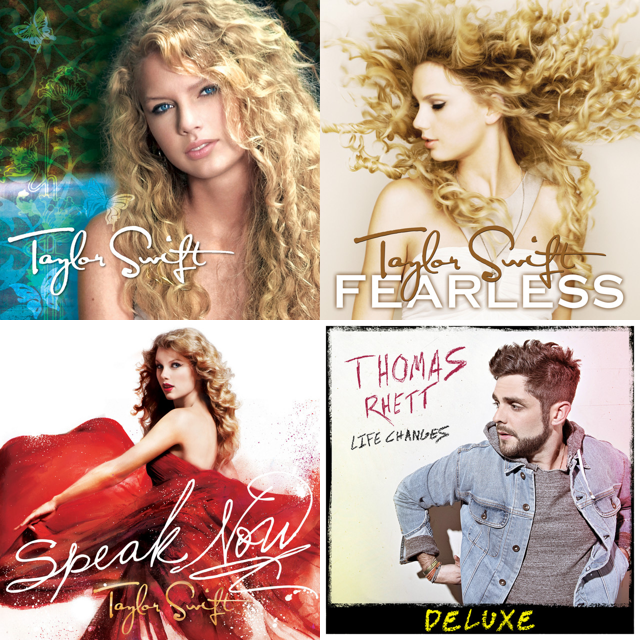

In [6]:
make_collage(2, test4)

## 3 x 3

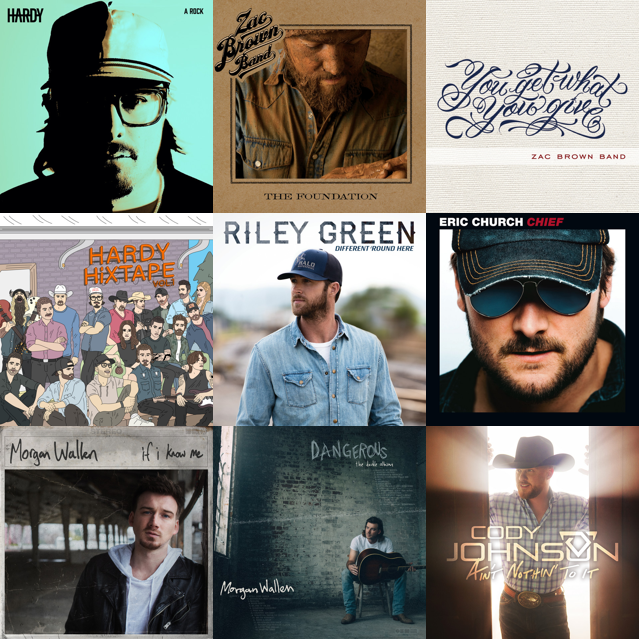

In [7]:
make_collage(3, test9)

## 4 x 4

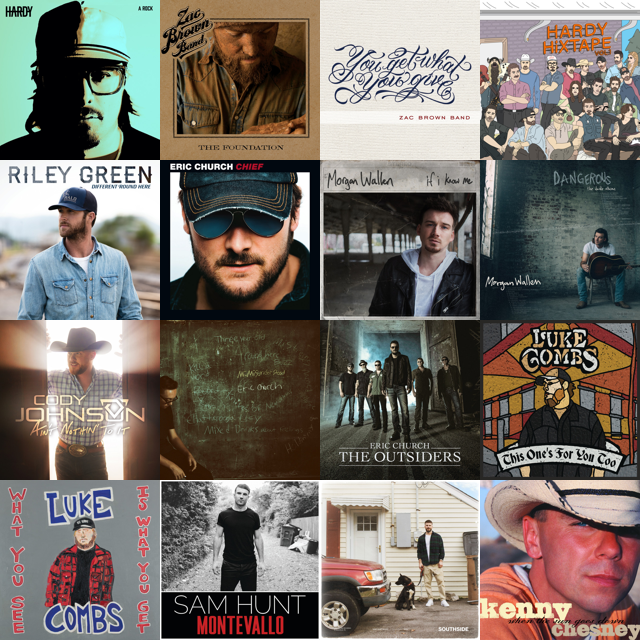

In [8]:
make_collage(4, test16)

## 4 x 4 with Centerpiece

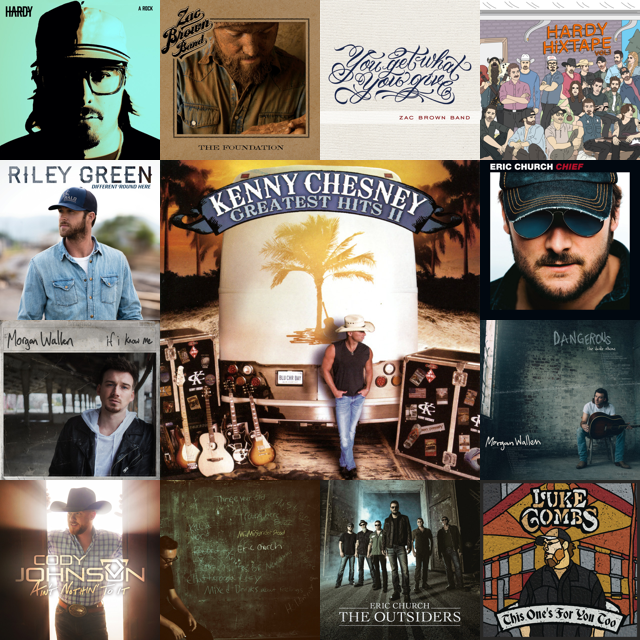

In [9]:
make_collage(4, test12, test1)

## 4 x 4 with Top/Bottom Borders

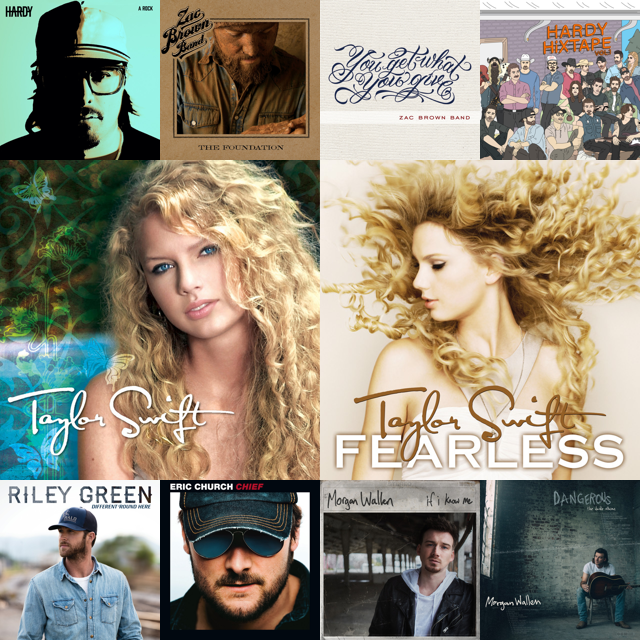

In [10]:
make_collage(4, test8, test2)

## 5 x 5

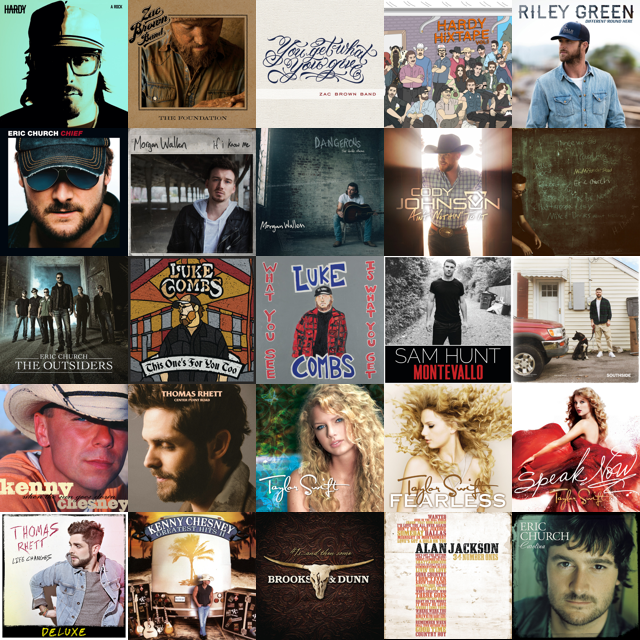

In [11]:
make_collage(5, test25)

## 5 x 5 with Corner Centerpieces

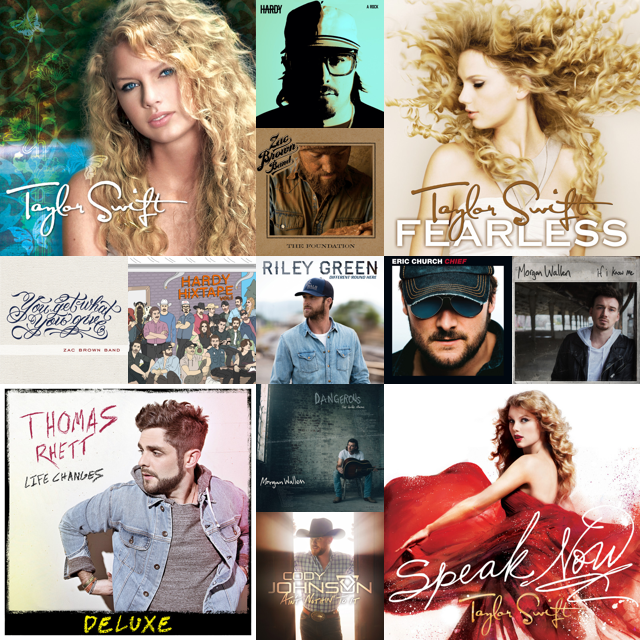

In [12]:
make_collage(5, test9, test4)

# Further Work...

- more design options
- simplify function arguments
    - remove `side_length` argument